# **LSTM**

In [6]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

data = pd.read_csv("product_sales_data.csv")
data['Date'] = pd.to_datetime(data['Date'])


products = data['ProductID'].unique()  # predict for each product individually because each product has its own trends
products=products[:1]
val_error=[]
train_error=[]
for product in products:
  product_data = data[data['ProductID'] == 1].drop(columns=['ProductID']) # currently predicting only for product 1
  df_for_training = product_data.drop(columns=['Date'])

  X_train = []
  y_train = []

  n_future = 1 # Number of days we want to look into the future based on the past days.
  n_past = 7 # Number of past days we want to use to predict the future.

  for i in range(n_past, len(df_for_training) - n_future +1):
     X_train.append(df_for_training.iloc[i - n_past:i, 0:df_for_training.shape[1]])
     y_train.append(df_for_training.iloc[i + n_future - 1:i + n_future, 0])

  X_train, y_train = np.array(X_train), np.array(y_train)




  model = Sequential()
  model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
  model.add(LSTM(32, activation='relu', return_sequences=False))
  model.add(Dropout(0.2))
  model.add(Dense(y_train.shape[1]))

  model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
  model.summary()
  history = model.fit(X_train, y_train, epochs=10, batch_size=8, validation_split=0.2, verbose=1)
  avg_train_loss = np.mean(history.history['loss'])
  train_error.append(avg_train_loss)
  avg_val_loss = np.mean(history.history['val_loss'])
  val_error.append(avg_val_loss)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 7, 64)             18176     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30625 (119.63 KB)
Trainable params: 30625 (119.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
146/146 [==============================] - 3s 9ms/step - loss: 246.1296 - val_loss: 93.6048
Epoch 2/10
146/146 [=========================

In [7]:
import statistics


average1 = statistics.mean(train_error)
print("Average training Error(RMSE):", np.sqrt(average1))

average2 = statistics.mean(val_error)
print("Average Valdiation Error(RMSE):", np.sqrt(average2))

Average training Error(RMSE): 11.760925472978606
Average Valdiation Error(RMSE): 8.781418464103577


In [9]:
product_data = data[data['ProductID'] == 1].drop(columns=['ProductID'])
df_for_training = product_data.drop(columns=['Date'])
X_train = []
y_train = []
n_future = 1
n_past = 7
for i in range(n_past, len(df_for_training) - n_future +1):
     X_train.append(df_for_training.iloc[i - n_past:i, 0:df_for_training.shape[1]])
     y_train.append(df_for_training.iloc[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
train_predictions = model.predict(X_train).flatten()
y_train=y_train.flatten()
test_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
test_results


46/46 [==============================] - 0s 3ms/step


,Train Predictions,Actuals
0,28.076635,29.0
1,27.224859,33.0
2,30.585930,40.0
3,39.440990,51.0
4,42.976505,45.0
...,...,...
1448,26.174923,37.0
1449,29.178467,26.0
1450,27.405617,25.0
1451,29.609339,29.0


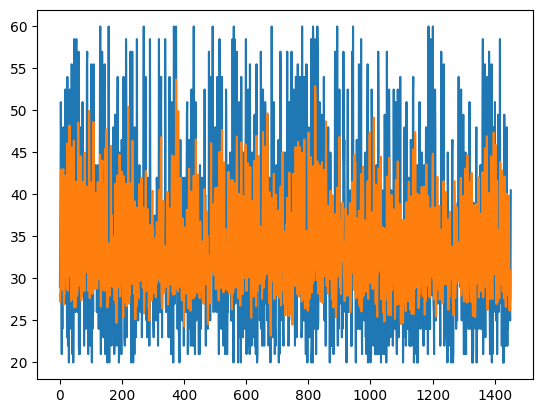

In [10]:

plt.plot(test_results['Actuals'][:])
plt.plot(test_results['Train Predictions'][:])

# **Combination of random forest and LSTM**

---



In [22]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

data = pd.read_csv("product_sales_data.csv")
data['Date'] = pd.to_datetime(data['Date'])

#Random forest for regression
X = data.drop(columns=['Date', 'Sales'])
y = data['Sales']
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)
RF_pre=model.predict(X)
data['Rf predictions']=RF_pre
mse = mean_squared_error(y, RF_pre)
mae = mean_absolute_error(y, RF_pre)

print(mse,mae)

# We can not use Random forest seperately because we have to make the trends of past data
data.head()

7.590778730308374 1.9509333561643838


,Date,ProductID,Sales,Price,CompetitionPrice,Holiday,StartingWeek,Weekend,Rf predictions
0,2020-01-01,11,60.0,106.80,99.58,0,1,0,53.58
1,2020-01-01,25,14.0,43.86,44.79,0,1,0,14.14
2,2020-01-01,13,17.0,50.63,48.06,0,1,0,16.61
3,2020-01-01,3,22.0,90.00,86.67,0,1,0,23.04
4,2020-01-01,10,22.0,72.97,78.28,0,1,0,21.46


In [24]:
#Now LSTM for time series forecasting

products = data['ProductID'].unique()
products=products[:1]
val_error=[]
train_error=[]

for product in products:
  product_data = data[data['ProductID'] == 1].drop(columns=['ProductID'])
  df = product_data.drop(columns=['Date','Price','CompetitionPrice','Holiday','StartingWeek','Weekend'])

  df_for_training=df

  X_train = []
  y_train = []

  n_future = 1 # Number of days we want to look into the future based on the past days.
  n_past = 7 # Number of past days we want to use to predict the future.

  for i in range(n_past, len(df_for_training) - n_future +1):
     X_train.append(df_for_training.iloc[i - n_past:i,:])
     y_train.append(df_for_training.iloc[i + n_future - 1:i + n_future,0])

  X_train, y_train = np.array(X_train), np.array(y_train)




  model1 = Sequential()
  model1.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
  model1.add(LSTM(32, activation='relu', return_sequences=False))
  model1.add(Dropout(0.2))
  model1.add(Dense(y_train.shape[1]))
  model1.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
  model1.summary()
  history = model1.fit(X_train, y_train, epochs=10, batch_size=8, validation_split=0.2, verbose=1)
  avg_train_loss = np.mean(history.history['loss'])
  train_error.append(avg_train_loss)
  avg_val_loss = np.mean(history.history['val_loss'])
  val_error.append(avg_val_loss)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 7, 64)             17152     
                                                                 
 lstm_13 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29601 (115.63 KB)
Trainable params: 29601 (115.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
146/146 [==============================] - 3s 9ms/step - loss: 262.7537 - val_loss: 77.5148
Epoch 2/10
146/146 [=========================

In [25]:
import statistics


average1 = statistics.mean(train_error)
print("Average training Error(RMSE):", np.sqrt(average1))

average2 = statistics.mean(val_error)
print("Average Valdiation Error(RMSE):", np.sqrt(average2))


Average training Error(RMSE): 11.398261764248875
Average Valdiation Error(RMSE): 8.020991537011893


In [27]:
product_data = data[data['ProductID'] == 1].drop(columns=['ProductID'])
df = product_data.drop(columns=['Date','Price','CompetitionPrice','Holiday','StartingWeek','Weekend'])
df_for_training=df

X_train = []
y_train = []
n_future = 1
n_past = 7
for i in range(n_past, len(df_for_training) - n_future +1):
     X_train.append(df_for_training.iloc[i - n_past:i,:])
     y_train.append(df_for_training.iloc[i + n_future - 1:i + n_future,0])

X_train, y_train = np.array(X_train), np.array(y_train)
lstm_pred = model1.predict(X_train).flatten()
y_train=y_train.flatten()

test_results = pd.DataFrame(data={'Train Predictions':lstm_pred, 'Actuals':y_train})
test_results


46/46 [==============================] - 0s 3ms/step


,Train Predictions,Actuals
0,31.400311,29.0
1,29.952957,33.0
2,32.192970,40.0
3,41.177452,51.0
4,44.476292,45.0
...,...,...
1448,28.538048,37.0
1449,32.253223,26.0
1450,27.507519,25.0
1451,29.471804,29.0


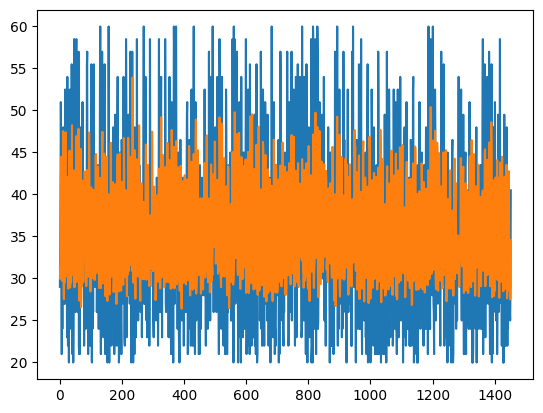

In [28]:

plt.plot(test_results['Actuals'][:])
plt.plot(test_results['Train Predictions'][:])